# Figures - First Submission
Script is primarily used to make the nice figures used in the manuscript.

In [1]:
# reset notebook variables and imports
%reset -f

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from scipy.stats import spearmanr
from collections import namedtuple
import imageio
from skimage.transform import resize
from PIL import Image, ImageDraw
sys.path.append('..')
from modules import plotting
from scipy import stats
from os.path import join as oj

In [2]:
# functions
Rectangle = namedtuple('Rectangle', 'xmin ymin xmax ymax')


def area(a, b):  # returns None if rectangles don't intersect
    dx = min(a.xmax, b.xmax) - max(a.xmin, b.xmin)
    dy = min(a.ymax, b.ymax) - max(a.ymin, b.ymin)
    if (dx>=0) and (dy>=0):
        return dx*dy
    else:
        return 0


def fov_correlation(data_path, fov_dir, n=1, plot=False):
    """Plot correlation of the average n denset FOV in each image vs the whole tissue image.
    
    :param data_path : str
        path to data file for case info, CERAD categories, and whole tissue scores
    :param fov_dir : str
        the dir containing the fov csv files for each case
    :param n : int (default of 1)
        the n highest FOV scores to use
    """
    labels=('cored', 'diffuse', 'caa')
    fov_labels = ('cored_densest_fov', 'diffuse_densest_fov', 'caa_densest_fov')
    tissue_labels = ('tissue_cored_score', 'tissue_diffuse_score', 'tissue_caa_score')
    category_labels = ('Cored_MTG', 'Diffuse_MTG', 'CAA_MTG')
    df = pd.read_csv(data_path)
    
    # add a column for densest FOV count for each case's plaques types (cored, diffuse, caa)
    densest_scores = [[], [], []]

    for idx, row in df.iterrows():
        # load the fov scores for this case
        fov_df = pd.read_csv(oj(fov_scores_dir, row['WSI_ID'] + '.csv'))

        for i, label in enumerate(labels):
            # subset each type of plaque
            df_subset = fov_df[fov_df['label']==label].reset_index(drop=True)
            
            # sort by counts
            df_subset = df_subset.sort_values(by=['count'], ascending=False).reset_index(drop=True)
            
            # df subset is 0 then just return 0
            if len(df_subset) == 0:
                densest_scores[i].append(0)
                continue
                            
            # take the n highest non-overlapping counts
            x, y = df_subset.loc[0, 'x'], df_subset.loc[0, 'y']
            w, h = df_subset.loc[0, 'width'], df_subset.loc[0, 'height']
            scores = [df_subset.loc[0, 'count'] * 100 / (w * h)]
            coords = [Rectangle(x, y, x + w, y + h)]
            
            for j in range(1, len(df_subset)):
                # if we already have the top n counts, then stop
                if len(scores) == n:
                    break
                    
                # else check the this region to make sure it does not overlap with previous regions
                x, y = df_subset.loc[j, 'x'], df_subset.loc[j, 'y']
                w, h = df_subset.loc[j, 'width'], df_subset.loc[j, 'height']
                r = Rectangle(x, y, x + w, y + h)
                
                # for all already region check
                flag = False
                for coord in coords:
                    if area(coord, r) != 0:
                        flag = True
                        break
                
                # if flag did not change to true then this region does not overlap, add it
                if not flag:
                    coords.append(r)
                    scores.append(df_subset.loc[j, 'count'] * 100 / (w * h))
                    
            # convert scores to average and append to denset list - note that there may be less than n 
            # entries if not enough non-overlapping regions
            densest_scores[i].append(sum(scores) / len(scores))
            
    # add the densest fov column (scores)
    for i in range(3):
        df[fov_labels[i]] = densest_scores[i]
        
    # sort the tissue scores and densest FOV scores and plot against each other
    rhos = []
    for i in range(3):
        tissue_scores = df[tissue_labels[i]].tolist()
        fov_scores = df[fov_labels[i]].tolist()
        
        # return spearman correlation with the CERAD like scores
        rho, p = spearmanr(fov_scores, df[category_labels[i]].tolist())
        rhos.append(rho)
        
        # calaculate spearman correlation between tissue and fov scores
        rho, p = spearmanr(tissue_scores, fov_scores)
#       
        
        # sort the lists together before plotting
        tissue_scores, fov_scores = (list(t) for t in zip(*sorted(zip(tissue_scores, fov_scores))))
        
        if plot:
            plt.figure(figsize=(7, 5))
            plt.plot(tissue_scores, fov_scores, '.-')
            plt.xlabel('Tissue CNN Scores', fontsize=16)
            plt.ylabel('{} FOV CNN-Scores'.format(n), fontsize=16)
            plt.title('r: {:0.3f}'.format(float(rho)))
            plt.show()

            x_param = {0: 'None', 1: 'Sparse', 2: 'Moderate', 3: 'Frequent'}
            plotting.plot_cnn_scores(df, category_labels[i], fov_labels[i], x_param, 
                                     ylabel='{} Highest FOV CNN-Scores'.format(n),
                                     xlabel='CERAD-like scores')
            
        
    return rhos

#### Fig 1. Whole tissue CNN scores vs CERAD-like categories
For all box plots a color scheme must be chosen. Cored: used red, diffuse use brown, and caa use blue

None count: 10
Sparse count: 13
Moderate count: 14
Frequent count: 3
None, Sparse: p-value of 0.0009494723489828976
None, Moderate: p-value of 2.4650032847156387e-05
None, Frequent: p-value of 5.697465532108909e-06
Sparse, Moderate: p-value of 0.1199020044390679
Sparse, Frequent: p-value of 0.0036418713660737
Moderate, Frequent: p-value of 0.030649286281996993


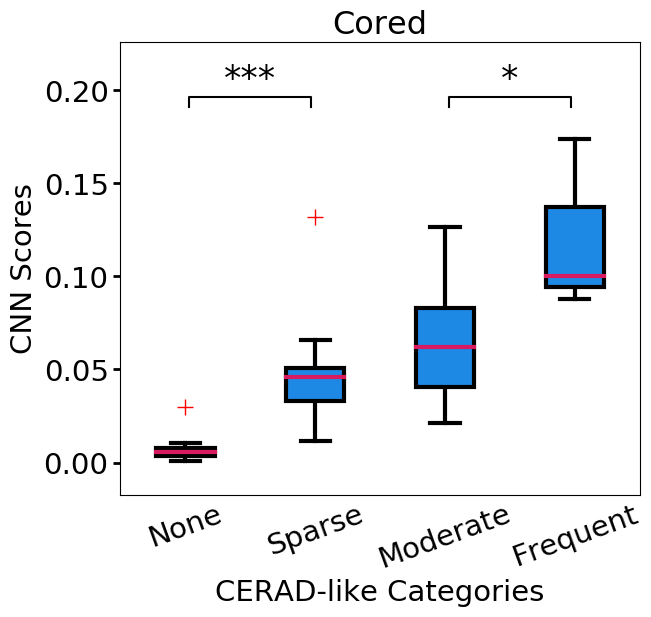

None count: 6
Sparse count: 3
Moderate count: 3
Frequent count: 28
None, Sparse: p-value of 0.14467224126487377
None, Moderate: p-value of 7.240482877160149e-07
None, Frequent: p-value of 1.0819608610815688e-06
Sparse, Moderate: p-value of 0.0026526039266780823
Sparse, Frequent: p-value of 0.000635479747866544
Moderate, Frequent: p-value of 0.18295682758455262


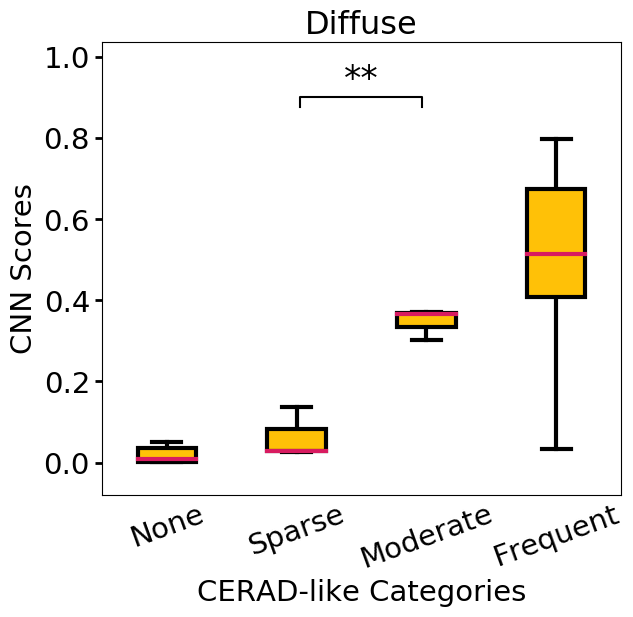

None count: 19
Sparse count: 5
Moderate count: 6
Frequent count: 10
None, Sparse: p-value of 0.7766259629159422
None, Moderate: p-value of 0.009631246172292156
None, Frequent: p-value of 0.0022379405791318353
Sparse, Moderate: p-value of 0.14948301568454805
Sparse, Frequent: p-value of 0.1023938235749198
Moderate, Frequent: p-value of 0.4631385139054517


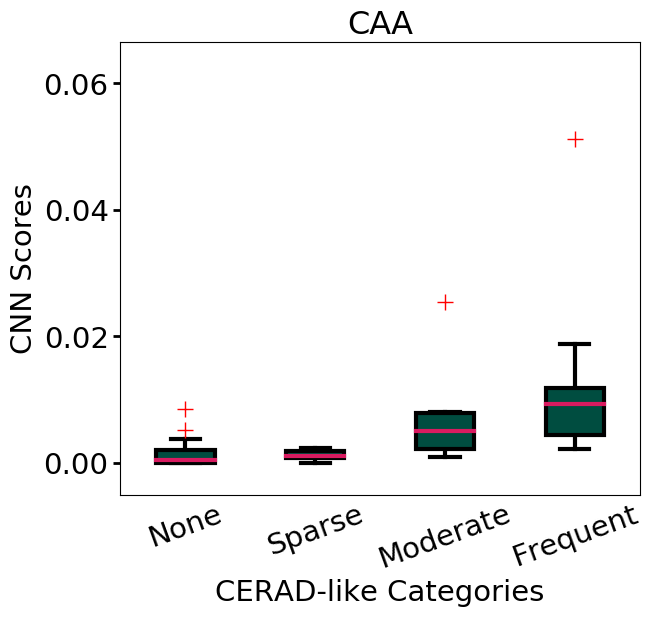

In [3]:
# read in data to plot
df = pd.read_csv('../CSVs/Emory_data.csv')

x_param = {0: 'None', 1: 'Sparse', 2: 'Moderate', 3: 'Frequent'}
plotting.plot_cnn_scores(df, 'Cored_MTG', 'tissue_cored_score', x_param, figsize=(6.7, 6), facecolor='#1E88E5',
                        labelsize=21, xlabel='CERAD-like Categories', ylabel='CNN Scores', fontsize=21,
                        title='Cored', rotation=20, save_name='fig1_part1.png')
plotting.plot_cnn_scores(df, 'Diffuse_MTG', 'tissue_diffuse_score', x_param, figsize=(6.7, 6), facecolor='#FFC107',
                        labelsize=21, xlabel='CERAD-like Categories', ylabel='CNN Scores', fontsize=21,
                        title='Diffuse', rotation=20, save_name='fig1_part2.png')
plotting.plot_cnn_scores(df, 'CAA_MTG', 'tissue_caa_score', x_param, figsize=(6.7, 6), facecolor='#004D40',
                        labelsize=21, xlabel='CERAD-like Categories', ylabel='CNN Scores', fontsize=21,
                        title='CAA', rotation=20, save_name='fig1_part3.png')

#### Fig 2. Comparing CNN scores from Tang and Emory Datasets based on CERAD-like groups
Use same color scheme as Fig 1 but change the look of the box plot.

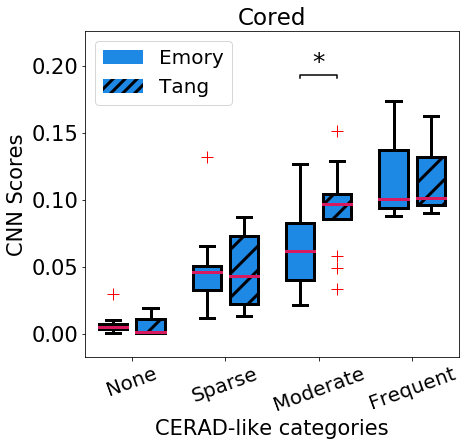

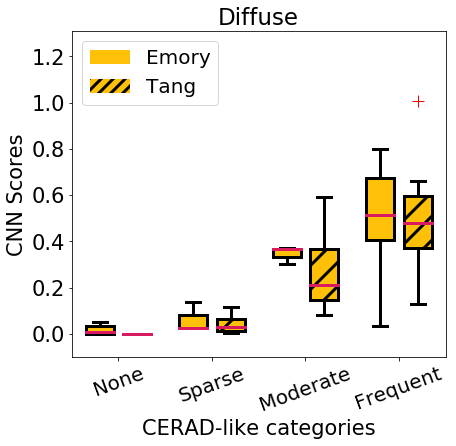

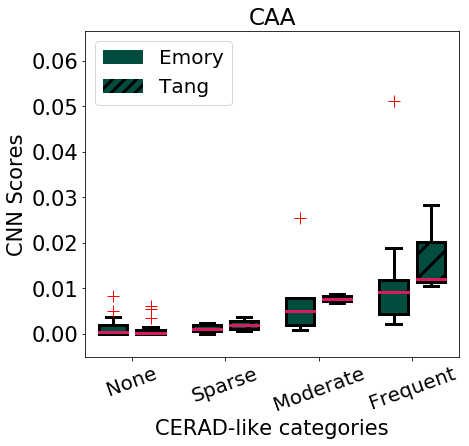

In [4]:
# read both datafiles and concatenate the data
df1 = pd.read_csv('../CSVs/Emory_data.csv')
df2 = pd.read_csv('../CSVs/Tang_data.csv')
df2 = df2[df2['Group'] == 'hold out'].reset_index(drop=True)

plotting.plot_grouped_box_plots(df1, df2, 'Cored_MTG', 'tissue_cored_score', ['Emory', 'Tang'],
                               facecolor='#1E88E5', figsize=(6.7, 6), xlabel='CERAD-like categories',
                               ylabel='CNN Scores', title='Cored', fontsize=21, labelsize=21,
                               xticks=['None', 'Sparse', 'Moderate', 'Frequent'], save_name='fig2_part1.png')
plotting.plot_grouped_box_plots(df1, df2, 'Diffuse_MTG', 'tissue_diffuse_score', ['Emory', 'Tang'],
                               facecolor='#FFC107', figsize=(6.7, 6), xlabel='CERAD-like categories',
                               ylabel='CNN Scores', title='Diffuse', fontsize=21, labelsize=21,
                               xticks=['None', 'Sparse', 'Moderate', 'Frequent'], save_name='fig2_part2.png')
plotting.plot_grouped_box_plots(df1, df2, 'CAA_MTG', 'tissue_caa_score', ['Emory', 'Tang'],
                               facecolor='#004D40', figsize=(6.7, 6), xlabel='CERAD-like categories',
                               ylabel='CNN Scores', title='CAA', fontsize=21, labelsize=21,
                               xticks=['None', 'Sparse', 'Moderate', 'Frequent'], save_name='fig2_part3.png')

#### Fig 3. Comparing CNN scores by CERAD-like categories using combined Emory & Tang dataset

In [ ]:
# read in data to plot
df1 = pd.read_csv('../CSVs/Emory_data.csv')
df2 = pd.read_csv('../CSVs/Tang_data.csv')
df2 = df2[df2['Group'] == 'hold out'].reset_index(drop=True)
df = pd.concat([df1, df2], sort=False)

x_param = {0: 'None', 1: 'Sparse', 2: 'Moderate', 3: 'Frequent'}
plotting.plot_cnn_scores(df, 'Cored_MTG', 'tissue_cored_score', x_param, figsize=(6.7, 6), facecolor='#1E88E5',
                        labelsize=21, xlabel='CERAD-like Categories', ylabel='CNN Scores', fontsize=21,
                        title='Cored', rotation=20, save_name='fig3_part1.png')
plotting.plot_cnn_scores(df, 'Diffuse_MTG', 'tissue_diffuse_score', x_param, figsize=(6.7, 6), facecolor='#FFC107',
                        labelsize=21, xlabel='CERAD-like Categories', ylabel='CNN Scores', fontsize=21,
                        title='Diffuse', rotation=20, save_name='fig3_part2.png')
plotting.plot_cnn_scores(df, 'CAA_MTG', 'tissue_caa_score', x_param, figsize=(6.7, 6), facecolor='#004D40',
                        labelsize=21, xlabel='CERAD-like Categories', ylabel='CNN Scores', fontsize=21,
                        title='CAA', rotation=20, save_name='fig3_part3.png')

#### 4. CNN score comparison by pathological diagnosis

In [ ]:
# format the diagnosis column
df = pd.read_csv('../CSVs/Emory_data.csv')
concomitant_dx = []
dx_columns = ['Primary Dx', 'Secondary Dx (1)', 'Secondary Dx (2)']

for index, row in df.iterrows():
    # concatenate the diagnosis column values
    dxs = [row[dx] for dx in dx_columns if row[dx] not in ['none', 'amyg LB']]
    
    # to simplify convert poss AD and prob AD to AD
    for i, dx in enumerate(dxs):
        if dx == 'prob AD':
            dxs[i] = 'AD'
    
    # if else clauses
    if len(dxs) == 1 and dxs[0] == 'control':
        concomitant_dx.append('control')
    elif len(dxs) == 1 and dxs[0] in ['AD', 'poss AD']:
        concomitant_dx.append('AD')
    elif 'AD' in dxs and 'DLB' not in dxs and 'TDP' not in dxs:
        concomitant_dx.append('AD')
    elif 'AD' in dxs and 'DLB' in dxs and 'TDP' not in dxs:
        concomitant_dx.append('AD+DLB')
    elif 'AD' in dxs and 'TDP' in dxs and 'DLB' not in dxs:
        concomitant_dx.append('AD+TDP')
    else:
        concomitant_dx.append('none')

# remove cases with none for concomitant
df['Concomitant Diagnosis'] = concomitant_dx
df = df[df['Concomitant Diagnosis'] != 'none'].reset_index(drop=True)

# plot CNN score comparisons for tissue CNN scores
x_param = {'control': 'control','AD': 'AD', 'AD+TDP': 'AD+TDP','AD+DLB': 'AD+DLB'}

plotting.plot_cnn_scores(df, 'Concomitant Diagnosis', 'tissue_cored_score', x_param, figsize=(6.7, 6), 
                        labelsize=21, xlabel='Pathological Diagnosis', ylabel='CNN Scores', fontsize=21,
                        title='Cored', rotation=20, facecolor='white', sig=False, 
                        save_name='fig4_part1.png')
plotting.plot_cnn_scores(df, 'Concomitant Diagnosis', 'tissue_diffuse_score', x_param, figsize=(6.7, 6), 
                        labelsize=21, xlabel='Pathological Diagnosis', ylabel='CNN Scores', fontsize=21,
                        title='Diffuse', rotation=20, facecolor='white', sig=False, 
                        save_name='fig4_part2.png')
plotting.plot_cnn_scores(df, 'Concomitant Diagnosis', 'tissue_caa_score', x_param, figsize=(6.7, 6), 
                        labelsize=21, xlabel='Pathological Diagnosis', ylabel='CNN Scores', fontsize=21,
                        title='CAA', rotation=20, facecolor='white', sig=False, 
                        save_name='fig4_part3.png')

In [ ]:
count = 0
for i, r in df.iterrows():
    second_dx = 'amyg LB'
    if r['Primary Dx'] == 'AD' and (r['Secondary Dx (1)'] == second_dx or r['Secondary Dx (2)'] == second_dx):
        count += 1
count

#### Fig 5. Whole tissue CNN scores for Emory data grouped by NIA criteria

In [ ]:
df = pd.read_csv('../CSVs/Emory_data.csv')

# group no and low together
grouped_reagen = ['none'] * len(df)
for i, r in df.iterrows():
    if r['Reagan'] in ['no', 'low']:
        grouped_reagen[i] = 'no/low'
    else:
        grouped_reagen[i] = r['Reagan']
        
df['grouped_reagen'] = grouped_reagen

x_param = {'no/low': 'no/low', 'intermediate': 'intermediate', 'high': 'high'}

plotting.plot_cnn_scores(df, 'grouped_reagen', 'tissue_cored_score', x_param, figsize=(6.7, 6), 
                        labelsize=21, xlabel='Reagan Score', ylabel='CNN Scores', fontsize=21,
                        title='Cored', rotation=0, facecolor='white', save_name='fig5_part1.png')
plotting.plot_cnn_scores(df, 'grouped_reagen', 'tissue_diffuse_score', x_param, figsize=(6.7, 6), 
                        labelsize=21, xlabel='Reagan Score', ylabel='CNN Scores', fontsize=21,
                        title='Diffuse', rotation=0, facecolor='white', save_name='fig5_part2.png')
plotting.plot_cnn_scores(df, 'grouped_reagen', 'tissue_caa_score', x_param, figsize=(6.7, 6), 
                        labelsize=21, xlabel='Reagan Score', ylabel='CNN Scores', fontsize=21,
                        title='CAA', rotation=0, facecolor='white', save_name='fig5_part3.png')

#### Fig 7. Comparison of Gray Matter vs Whole Tissue Scores

Part 1 of figure 7 - comparing correlation coefficients for scores from whole tissue and gray matter when correlating with ordinal categories: CERAD-like categories and Reagan criteria.

In [ ]:
df = pd.read_csv('../CSVs/Emory_data.csv')

# for CERAD comparisons calcualte the spearman correlation coeff for three pathologies for gm and tissue
cerad_cols = ['Cored_MTG', 'Diffuse_MTG', 'CAA_MTG']

tissue_rs = []
gm_rs = []
for cerad_col in cerad_cols:
    cerad_vals = df[cerad_col].tolist()
    tissue_vals = df['tissue_{}_score'.format(cerad_col.split('_')[0].lower())].tolist()
    gm_vals = df['gm_{}_score'.format(cerad_col.split('_')[0].lower())].tolist()
    r1, _ = spearmanr(cerad_vals, tissue_vals)
    r2, _ = spearmanr(cerad_vals, gm_vals)
    tissue_rs.append(r1)
    gm_rs.append(r2)
    

# group no and low together
grouped_reagan = [-1] * len(df)
for i, r in df.iterrows():
    if r['Reagan'] == 'no':
        grouped_reagan[i] = 0
    elif r['Reagan'] == 'low':
        grouped_reagan[i] = 1
    elif r['Reagan'] == 'intermediate':
        grouped_reagan[i] = 2
    else:
        grouped_reagan[i] = 3
        
df['grouped_reagan'] = grouped_reagan
        
# calculate r coefficients for Reagan
for pathology in ['cored', 'diffuse', 'caa']:
    reagan_vals = df['grouped_reagan'].tolist()
    tissue_vals = df['tissue_{}_score'.format(pathology)].tolist()
    gm_vals = df['gm_{}_score'.format(pathology)].tolist()
        
    r1, _ = spearmanr(reagan_vals, tissue_vals)
    r2, _ = spearmanr(reagan_vals, gm_vals)
    tissue_rs.append(r1)
    gm_rs.append(r2)
    
# plot comparison bar plots
fig = plt.figure(figsize=(7.5, 7))
ax = fig.add_subplot(111)

# Set position of bar on X axis
barWidth = 0.3
ind = np.arange(6)
 
# Make the plot
ax.barh(ind + barWidth, tissue_rs, barWidth, color='white', edgecolor='black', label='Whole Tissue')
ax.barh(ind, gm_rs, barWidth, color='gray', edgecolor='black', label='Gray Matter')
ax.yaxis.set_tick_params(labelsize=18, size=0, width=2)
ax.xaxis.set_tick_params(labelsize=18, size=5, width=2)
ax.set_xlabel("Spearman's Coefficient", fontsize=18)
ax.set(yticks=ind + barWidth, 
       yticklabels=['CERAD-like (cored)','CERAD-like (diffuse)','CERAD-like (CAA)',
                    'Reagan (cored)','Reagan (diffuse)', 'Reagan (caa)'], 
                    ylim=[2*barWidth - 1, 6])
ax.set_xlim([0, 1])
ax.legend(fontsize=18)
fig.savefig('fig7_part1.png', bbox_inches='tight', dpi=300)
plt.pause(0.001)
plt.show()

Part 2 - CNN score increases for gray matter vs whole tissue for three pathologies

In [ ]:
# for each case calculate the percentage increase in CNN score (three calculations for each pathology)
changes = [[], [], []]
colors = ['#1E88E5', '#FFC107', '#004D40']

df = pd.read_csv('../CSVs/Emory_data.csv')


def percent_change(new_val, old_val):
    return 100 * (new_val - old_val) / old_val


for i, r in df.iterrows():
    for j, pathology in enumerate(['cored', 'diffuse', 'caa']):
        new_val = r['gm_{}_score'.format(pathology)]
        old_val = r['tissue_{}_score'.format(pathology)]
        
        if old_val != 0:
            change = percent_change(new_val, old_val)
        else:
            change = 0
            
        changes[j].append(change)
        
df['cored_change'] = changes[0]
df['diffuse_change'] = changes[1]
df['caa_change'] = changes[2]

# compare the CNN score change for all data
np.mean(changes[0]), np.mean(changes[1]), np.mean(changes[2])

# make the line plot for comparing whole tissue and gm scores for each pathology in ordered fashion
labels = ['Cored', 'Diffuse', 'CAA']
for i, pathology in enumerate(['cored', 'diffuse', 'caa']):
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(111)
    tissue_scores = df['tissue_{}_score'.format(pathology)].tolist()
    gm_scores = df['gm_{}_score'.format(pathology)].tolist()
    
    tissue_scores, gm_scores = (list(t) for t in zip(*sorted(zip(tissue_scores, gm_scores))))
    plt.plot(tissue_scores, colors[i])
    plt.plot(gm_scores, colors[i], linestyle='--')
    plt.title(labels[i], fontsize=18)
    plt.xlabel('Cases', fontsize=18)
    if i == 0:
        plt.ylabel('CNN scores', fontsize=18)
    ax.yaxis.set_tick_params(labelsize=18, size=5, width=2)
    ax.xaxis.set_tick_params(labelsize=18, size=5, width=2)
#     plt.legend(['Whole Tissue', 'Gray Matter'], fontsize=18)

    fig.savefig('fig7_part{}.png'.format(i+2), bbox_inches='tight', dpi=300)
    plt.pause(0.001)
    plt.show()

Potential part 3 here is comparing amount of gray matter in AD vs control cases. Two ways to do this: control vs all cases with an AD diagnosis (prob AD, poss AD, ignoring all other concomitant pathologies). Or doing the control vs AD vs AD+TDP vs AD+DLB.

In [ ]:
# add a pathology column
df = pd.read_csv('../CSVs/Emory_data.csv')

dxs = []

for i, r in df.iterrows():
    if r['Primary Dx'] == 'control' and r['Secondary Dx (1)'] == 'none':
        dxs.append('control')
    elif r['Primary Dx'] in ['AD', 'prob AD', 'poss AD']:
        dxs.append('AD')
    elif r['Secondary Dx (1)'] in ['AD', 'prob AD', 'poss AD']:
        dxs.append('AD')  
    elif r['Secondary Dx (2)'] in ['AD', 'prob AD', 'poss AD']:
        dxs.append('AD')
    else:
        dxs.append('something else')
        
df['dxs'] = dxs

# for each of the diagnosis groups (AD and control) do a student t-test on gray matter pixels
ad_counts = df[df['dxs'] == 'AD']['gm_px_count'].tolist()
control_counts = df[df['dxs'] == 'control']['gm_px_count'].tolist()
_, p = stats.ttest_ind(ad_counts, control_counts, nan_policy='omit')
print(p)


# group more stringent and remove concomitant diagnosis
df = pd.read_csv('../CSVs/Emory_data.csv')

dxs = []

for i, r in df.iterrows():
    if r['Primary Dx'] == 'control' and r['Secondary Dx (1)'] == 'none':
        dxs.append('control')
    else:
        d = [r['Primary Dx'], r['Secondary Dx (1)'], r['Secondary Dx (2)']]
        if ('AD' in d or 'poss AD' in d or 'prob AD' in d) and 'DLB' not in d and 'TDP' not in d:
            dxs.append('AD')
        else:
            dxs.append('something else')
            
df['dxs'] = dxs
# for each of the diagnosis groups (AD and control) do a student t-test on gray matter pixels
ad_counts = df[df['dxs'] == 'AD']['gm_px_count'].tolist()
control_counts = df[df['dxs'] == 'control']['gm_px_count'].tolist()
_, p = stats.ttest_ind(ad_counts, control_counts, nan_policy='omit')
print(p)


#### Fig 8 - FOV figure

In [5]:
Rectangle = namedtuple('Rectangle', 'xmin ymin xmax ymax')


def area(a, b):  # returns None if rectangles don't intersect
    dx = min(a.xmax, b.xmax) - max(a.xmin, b.xmin)
    dy = min(a.ymax, b.ymax) - max(a.ymin, b.ymin)
    if (dx>=0) and (dy>=0):
        return dx*dy
    else:
        return 0
    

fov_df = pd.read_csv('/mnt/Data/outputs/fov_scores/A05-132_AB_1D.csv')
hm = np.load('/mnt/Data/outputs/heatmaps_emory/A05-132_AB_1D.npy')[0]
im = imageio.imread('/mnt/Data/figures/A05-132_AB_1D_thumbnail.jpeg')
im = resize(im, hm.shape)  

# just show a cored example
df_subset = fov_df[fov_df['label']=='cored'].reset_index(drop=True)

# sort by counts
df_subset = df_subset.sort_values(by=['count'], ascending=False).reset_index(drop=True)

# take the n highest non-overlapping counts
x, y = df_subset.loc[0, 'x'], df_subset.loc[0, 'y']
w, h = df_subset.loc[0, 'width'], df_subset.loc[0, 'height']
scores = [df_subset.loc[0, 'count'] * 100 / (w * h)]
coords = [Rectangle(x, y, x + w, y + h)]
            
n = 3
for j in range(1, len(df_subset)):
    # if we already have the top n counts, then stop
    if len(scores) == n:
        break
                    
    # else check the this region to make sure it does not overlap with previous regions
    x, y = df_subset.loc[j, 'x'], df_subset.loc[j, 'y']
    w, h = df_subset.loc[j, 'width'], df_subset.loc[j, 'height']
    r = Rectangle(x, y, x + w, y + h)
                
    # for all already region check
    flag = False
    for coord in coords:
        if area(coord, r) != 0:
            flag = True
            break
                
    # if flag did not change to true then this region does not overlap, add it
    if not flag:
        coords.append(r)
        scores.append(df_subset.loc[j, 'count'] * 100 / (w * h))

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [6]:
def draw_rectangle(draw, coordinates, color, width=1):
    for i in range(width):
        rect_start = (coordinates[0][0] - i, coordinates[0][1] - i)
        rect_end = (coordinates[1][0] + i, coordinates[1][1] + i)
        draw.rectangle((rect_start, rect_end), outline = color)

        
# draw the regions on the image
im_copy = Image.fromarray((im * 255).astype(np.uint8))
draw = ImageDraw.Draw(im_copy)

outline_width = 10
colors = ['black', 'black', 'black']

for i, coord in enumerate(coords):
    draw_rectangle(draw, [(coord.xmin, coord.ymin), (coord.xmax, coord.ymax)], color=colors[i],
                  width=outline_width)
del draw
    
im_copy.save('fig8_part1.png')

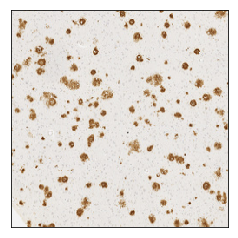

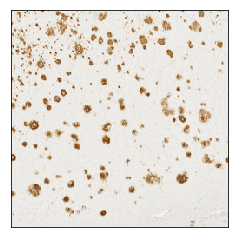

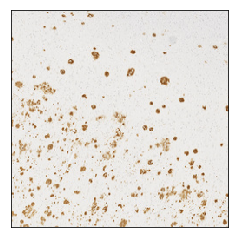

In [9]:
# save the close up image of the three parts
zoom_ims = []

for i, c in enumerate(coords):
    fig = plt.figure()
    frame = plt.gca()
    plt.imshow(im[c.ymin:c.ymax, c.xmin:c.xmax, :])
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    fig.savefig('fig8_part{}.png'.format(i + 2), bbox_inches='tight', dpi=300)
    plt.pause(0.001)
    plt.show()

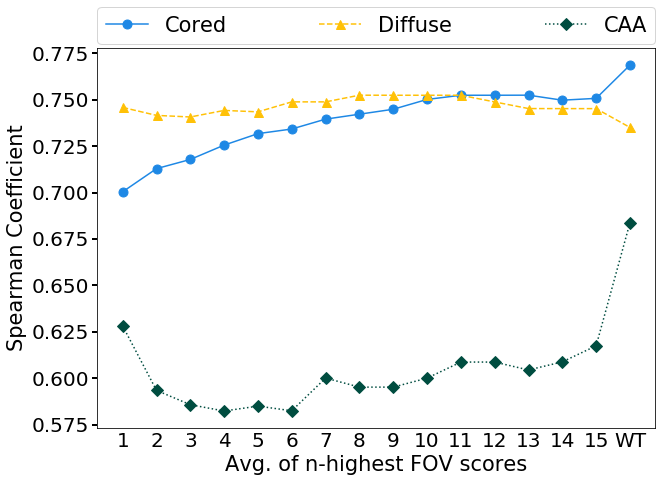

In [33]:
# for each plauqe get the spearman correlation coeff between the n average FOV vs CERAD categories
from os.path import join as oj

data_path = '/mnt/AB_Plaque_Box/CSVs/Emory_data.csv'
fov_scores_dir = '/mnt/Data/outputs/fov_scores/'
colors = ['#1E88E5', '#FFC107', '#004D40']
linestyles = ['solid', 'dashed', 'dotted']
markerstyles = ['o', '^', 'D']
df = pd.read_csv(data_path)

output = []
N = 16
for n in range(1, N):
    rhos = fov_correlation(data_path, fov_scores_dir, n=n)
    output.append(rhos)
    
output = np.array(output)

# add the spearman corrrelation coeff for whole tissue as last point
r_cored, p = spearmanr(df['Cored_MTG'].tolist(), df['tissue_cored_score'].tolist())
r_diffuse, p = spearmanr(df['Diffuse_MTG'].tolist(), df['tissue_diffuse_score'].tolist())
r_caa, p = spearmanr(df['CAA_MTG'].tolist(), df['tissue_caa_score'].tolist())
r_tissue = [r_cored, r_diffuse, r_caa]

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
x = list(range(1, N+1))
for i in range(3):
    fov_scores = list(output[:, i]) + [r_tissue[i]]
    ax.plot(x, fov_scores, color=colors[i], linestyle=linestyles[i], marker=markerstyles[i], markersize=9)
    ax.set_xticks(x)
    x_tick_labels = [str(_x) for _x in x[:-1]] + ['WT']
    ax.set_xticklabels(x_tick_labels)
ax.legend(['Cored', 'Diffuse', 'CAA'], fontsize=21, loc=3, ncol=3, mode='expand', borderaxespad=0.,
         bbox_to_anchor=(0., 1.01, 1., .102))# loc='best')
ax.set_ylabel('Spearman Coefficient', fontsize=21)
ax.xaxis.set_tick_params(labelsize=20, size=0, width=2)
ax.yaxis.set_tick_params(labelsize=20, size=5, width=2)
ax.set_xlabel('Avg. of n-highest FOV scores', fontsize=21)

fig.savefig('fig8_part5.png', bbox_inches='tight', dpi=300)
plt.pause(0.001)
plt.show()

#### Extra
Repeat the analysis before with just using the highest FOV scores.

In [ ]:
# for each case add the highest fov score
fov_scores_dir = '/mnt/Data/outputs/fov_scores/'
df = pd.read_csv('../CSVs/Emory_data.csv')

fov_scores = [[], [], []]

for i, r in df.iterrows():
    fov_df = pd.read_csv(oj(fov_scores_dir, r['WSI_ID'] + '.csv'))
    
    for j, p in enumerate(['cored', 'diffuse', 'caa']):
        temp = fov_df[fov_df['label']==p]
        
        if len(temp) == 0:
            fov_scores[j].append(0)
        else:
            fov_scores[j].append(temp.max(0)['count'])

df['fov_cored_score'] = fov_scores[0]
df['fov_diffuse_score'] = fov_scores[1]
df['fov_caa_score'] = fov_scores[2]

In [ ]:
x_param = {0: 'None', 1: 'Sparse', 2: 'Moderate', 3: 'Frequent'}
plotting.plot_cnn_scores(df, 'Cored_MTG', 'fov_cored_score', x_param, figsize=(6.7, 6), facecolor='#1E88E5',
                        labelsize=21, xlabel='CERAD-like Categories', ylabel='CNN Scores (FOV)', fontsize=21,
                        title='Cored', rotation=20)
plotting.plot_cnn_scores(df, 'Diffuse_MTG', 'fov_diffuse_score', x_param, figsize=(6.7, 6), facecolor='#FFC107',
                        labelsize=21, xlabel='CERAD-like Categories', ylabel='CNN Scores (FOV)', fontsize=21,
                        title='Diffuse', rotation=20)
plotting.plot_cnn_scores(df, 'CAA_MTG', 'fov_caa_score', x_param, figsize=(6.7, 6), facecolor='#004D40',
                        labelsize=21, xlabel='CERAD-like Categories', ylabel='CNN Scores (FOV)', fontsize=21,
                        title='CAA', rotation=20)

In [ ]:
concomitant_dx = []
dx_columns = ['Primary Dx', 'Secondary Dx (1)', 'Secondary Dx (2)']

for index, row in df.iterrows():
    # concatenate the diagnosis column values
    dxs = [row[dx] for dx in dx_columns if row[dx] not in ['none', 'amyg LB']]
    
    # to simplify convert poss AD and prob AD to AD
    for i, dx in enumerate(dxs):
        if dx in ['poss AD', 'prob AD']:
            dxs[i] = 'AD'
    
    # if else clauses
    if len(dxs) == 1 and dxs[0] == 'control':
        concomitant_dx.append('control')
    elif len(dxs) == 1 and dxs[0] == 'AD':
        concomitant_dx.append('AD')
    elif 'AD' in dxs and 'DLB' not in dxs and 'TDP' not in dxs:
        concomitant_dx.append('AD')
    elif 'AD' in dxs and 'DLB' in dxs and 'TDP' not in dxs:
        concomitant_dx.append('AD+DLB')
    elif 'AD' in dxs and 'TDP' in dxs and 'DLB' not in dxs:
        concomitant_dx.append('AD+TDP')
    else:
        concomitant_dx.append('none')

# remove cases with none for concomitant
df['Concomitant Diagnosis'] = concomitant_dx
df_temp = df[df['Concomitant Diagnosis'] != 'none'].reset_index(drop=True)

# plot CNN score comparisons for tissue CNN scores
x_param = {'control': 'control', 'AD': 'AD', 'AD+TDP': 'AD+TDP','AD+DLB': 'AD+DLB'}

plotting.plot_cnn_scores(df_temp, 'Concomitant Diagnosis', 'fov_cored_score', x_param, figsize=(6.7, 6), 
                        labelsize=21, xlabel='Pathological Diagnosis', ylabel='CNN Scores (FOV)', fontsize=21,
                        title='Cored', rotation=20, facecolor='white', sig=True)
plotting.plot_cnn_scores(df_temp, 'Concomitant Diagnosis', 'fov_diffuse_score', x_param, figsize=(6.7, 6), 
                        labelsize=21, xlabel='Pathological Diagnosis', ylabel='CNN Scores (FOV)', fontsize=21,
                        title='Diffuse', rotation=20, facecolor='white', sig=True)
plotting.plot_cnn_scores(df_temp, 'Concomitant Diagnosis', 'fov_caa_score', x_param, figsize=(6.7, 6), 
                        labelsize=21, xlabel='Pathological Diagnosis', ylabel='CNN Scores (FOV)', fontsize=21,
                        title='CAA', rotation=20, facecolor='white', sig=True)

In [ ]:
# group no and low together
grouped_reagen = ['none'] * len(df)
for i, r in df.iterrows():
    if r['Reagan'] in ['no', 'low']:
        grouped_reagen[i] = 'no/low'
    else:
        grouped_reagen[i] = r['Reagan']
        
df['grouped_reagen'] = grouped_reagen

x_param = {'no/low': 'no/low', 'intermediate': 'intermediate', 'high': 'high'}

plotting.plot_cnn_scores(df, 'grouped_reagen', 'fov_cored_score', x_param, figsize=(6.7, 6), 
                        labelsize=21, xlabel='Reagan Score', ylabel='CNN Scores (FOV)', fontsize=21,
                        title='Cored', rotation=0, facecolor='white')
plotting.plot_cnn_scores(df, 'grouped_reagen', 'fov_diffuse_score', x_param, figsize=(6.7, 6), 
                        labelsize=21, xlabel='Reagan Score', ylabel='CNN Scores (FOV)', fontsize=21,
                        title='Diffuse', rotation=0, facecolor='white')
plotting.plot_cnn_scores(df, 'grouped_reagen', 'fov_caa_score', x_param, figsize=(6.7, 6), 
                        labelsize=21, xlabel='Reagan Score', ylabel='CNN Scores (FOV)', fontsize=21,
                        title='CAA', rotation=0, facecolor='white')